# Data preparation & data transformation

In [1]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('data_preparation_transformation').getOrCreate()

In [2]:
# Importing data which has a header. Schema is automatically configured.
df1 = spark.read.csv('./houseprice1.csv', header=True, inferSchema=True) 
df2 = spark.read.csv('./houseprice2.csv', header=True, inferSchema=True) 

In [3]:
print("houseprice1.csv", (df1.count(), len(df1.columns)))
print("houseprice2.csv", (df2.count(), len(df2.columns)))

houseprice1.csv (1460, 81)
houseprice2.csv (1459, 81)


In [4]:
dropped_cols = ['Id','Street','Utilities','LandSlope','Condition2','RoofMatl','Heating','GarageCond','PoolQC']

df1 = df1.drop(*dropped_cols)
df2 = df2.drop(*dropped_cols)

In [5]:
print("houseprice1.csv", (df1.count(), len(df1.columns)))
print("houseprice2.csv", (df2.count(), len(df2.columns)))

houseprice1.csv (1460, 72)
houseprice2.csv (1459, 72)


In [6]:
# we drop the variables with more than 50% missing values
dropped_cols = ['Alley','MasVnrType','PoolQC','Fence','MiscFeature','FireplaceQu']

df1 = df1.drop(*dropped_cols)
df2 = df2.drop(*dropped_cols)

In [7]:
print("houseprice1.csv", (df1.count(), len(df1.columns)))
print("houseprice2.csv", (df2.count(), len(df2.columns)))

houseprice1.csv (1460, 67)
houseprice2.csv (1459, 67)


In [8]:
# We only consider the numeric columns which are more reliable and meaningful in prediction.
selected_variables = [x[0] for x in df1.dtypes if (x[1] != 'string') & (x[0] != 'Id')]
df1_s = df1[selected_variables]
df2_s = df2[selected_variables]
print(df1_s.count(),len(df1_s.columns))
print(df2_s.count(),len(df2_s.columns))

1460 34
1459 34


In [11]:
# remove nulls
from pyspark.sql.functions import isnan, when, count, col
print( df1_s.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df1_s.columns]).show() )
print( df2_s.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df2_s.columns]).show() )

+----------+-------+-----------+-----------+---------+------------+----------+----------+---------+-----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+------------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+-------+------+------+---------+
|MSSubClass|LotArea|OverallQual|OverallCond|YearBuilt|YearRemodAdd|BsmtFinSF1|BsmtFinSF2|BsmtUnfSF|TotalBsmtSF|1stFlrSF|2ndFlrSF|LowQualFinSF|GrLivArea|BsmtFullBath|BsmtHalfBath|FullBath|HalfBath|BedroomAbvGr|KitchenAbvGr|TotRmsAbvGrd|Fireplaces|GarageCars|GarageArea|WoodDeckSF|OpenPorchSF|EnclosedPorch|3SsnPorch|ScreenPorch|PoolArea|MiscVal|MoSold|YrSold|SalePrice|
+----------+-------+-----------+-----------+---------+------------+----------+----------+---------+-----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+------------+----------+----------+-----

In [12]:
# remove the outliers
import matplotlib.pyplot as plt
plt.boxplot("LotArea", data = df1_s.toPandas())

{'boxes': [<matplotlib.lines.Line2D at 0x7f8722df0908>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8722ed0358>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8722ed0fd0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8722ed0ba8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8722df0a58>,
  <matplotlib.lines.Line2D at 0x7f8722df0ef0>]}

{'boxes': [<matplotlib.lines.Line2D at 0x7f8722e285c0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8722e28fd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8722e21c88>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8722e21860>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8722e28710>,
  <matplotlib.lines.Line2D at 0x7f8722e28ba8>]}

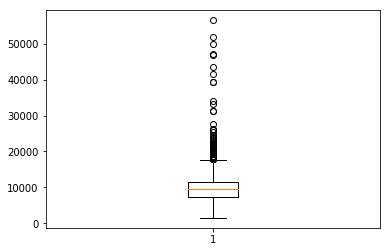

In [13]:
plt.boxplot("LotArea", data = df2_s.toPandas())

In [14]:
import pyspark.sql.functions as F

def remove_outliers(df):
    stats = df.agg(
        F.stddev_pop(F.col('LotArea')).alias("m_sd"),
        F.mean(F.col('LotArea')).alias("m_avg")).first().asDict()
    df = df.withColumn(
        'LotArea_z', F.abs(df['LotArea'] - stats['m_avg'])/stats['m_sd']
                   )
    df = df.filter('LotArea_z <= 1')
    return df

{'boxes': [<matplotlib.lines.Line2D at 0x7f8720d50518>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8720d50f28>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8720d59be0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8720d597b8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8720d50668>,
  <matplotlib.lines.Line2D at 0x7f8720d50b00>]}

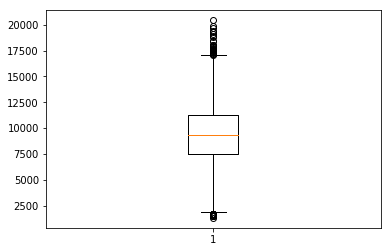

In [15]:
df1_s = remove_outliers(df1_s)

plt.boxplot("LotArea",data = df1_s.toPandas())

{'boxes': [<matplotlib.lines.Line2D at 0x7f8720d1f908>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8720d03358>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8720d03fd0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8720d03ba8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8720d1fa58>,
  <matplotlib.lines.Line2D at 0x7f8720d1fef0>]}

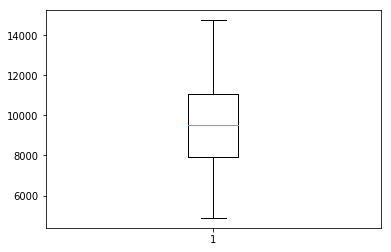

In [16]:
df2_s = remove_outliers(df2_s)

plt.boxplot("LotArea",data = df2_s.toPandas())

In [17]:
print(df1_s.count(),len(df1_s.columns))
print(df2_s.count(),len(df2_s.columns))

1408 35
1182 35


In [18]:
# Construct new variable TotalSF
df1_s_t = df1_s.withColumn("TotalSF", df1_s['1stFlrSF'] + df1_s['2ndFlrSF'])
df2_s_t = df2_s.withColumn("TotalSF", df2_s['1stFlrSF'] + df2_s['2ndFlrSF'])

In [19]:
print(df1_s_t.count(),len(df1_s_t.columns))
print(df2_s_t.count(),len(df2_s_t.columns))

1408 36
1182 36


In [20]:
print(df1_s_t.head(2))

[Row(MSSubClass=60, LotArea=8450, OverallQual=7, OverallCond=5, YearBuilt=2003, YearRemodAdd=2003, BsmtFinSF1=706, BsmtFinSF2=0, BsmtUnfSF=150, TotalBsmtSF=856, 1stFlrSF=856, 2ndFlrSF=854, LowQualFinSF=0, GrLivArea=1710, BsmtFullBath=1, BsmtHalfBath=0, FullBath=2, HalfBath=1, BedroomAbvGr=3, KitchenAbvGr=1, TotRmsAbvGrd=8, Fireplaces=0, GarageCars=2, GarageArea=548, WoodDeckSF=0, OpenPorchSF=61, EnclosedPorch=0, 3SsnPorch=0, ScreenPorch=0, PoolArea=0, MiscVal=0, MoSold=2, YrSold=2008, SalePrice=208500, LotArea_z=0.20714170777431135, TotalSF=1710), Row(MSSubClass=20, LotArea=9600, OverallQual=6, OverallCond=8, YearBuilt=1976, YearRemodAdd=1976, BsmtFinSF1=978, BsmtFinSF2=0, BsmtUnfSF=284, TotalBsmtSF=1262, 1stFlrSF=1262, 2ndFlrSF=0, LowQualFinSF=0, GrLivArea=1262, BsmtFullBath=0, BsmtHalfBath=1, FullBath=2, HalfBath=0, BedroomAbvGr=3, KitchenAbvGr=1, TotRmsAbvGrd=6, Fireplaces=1, GarageCars=2, GarageArea=460, WoodDeckSF=298, OpenPorchSF=0, EnclosedPorch=0, 3SsnPorch=0, ScreenPorch=0, Po

In [21]:
df1_s_t = df1_s_t.drop('1stFlrSF','2ndFlrSF')

In [22]:
df2_s_t = df2_s_t.drop('1stFlrSF','2ndFlrSF')

In [23]:
print(df1_s_t.count(),len(df1_s_t.columns))
print(df2_s_t.count(),len(df2_s_t.columns))

1408 34
1182 34


In [24]:
df1_s_t.printSchema

<bound method DataFrame.printSchema of DataFrame[MSSubClass: int, LotArea: int, OverallQual: int, OverallCond: int, YearBuilt: int, YearRemodAdd: int, BsmtFinSF1: int, BsmtFinSF2: int, BsmtUnfSF: int, TotalBsmtSF: int, LowQualFinSF: int, GrLivArea: int, BsmtFullBath: int, BsmtHalfBath: int, FullBath: int, HalfBath: int, BedroomAbvGr: int, KitchenAbvGr: int, TotRmsAbvGrd: int, Fireplaces: int, GarageCars: int, GarageArea: int, WoodDeckSF: int, OpenPorchSF: int, EnclosedPorch: int, 3SsnPorch: int, ScreenPorch: int, PoolArea: int, MiscVal: int, MoSold: int, YrSold: int, SalePrice: int, LotArea_z: double, TotalSF: int]>

In [25]:
df2_s_t.printSchema

<bound method DataFrame.printSchema of DataFrame[MSSubClass: int, LotArea: int, OverallQual: int, OverallCond: int, YearBuilt: int, YearRemodAdd: int, BsmtFinSF1: string, BsmtFinSF2: string, BsmtUnfSF: string, TotalBsmtSF: string, LowQualFinSF: int, GrLivArea: int, BsmtFullBath: string, BsmtHalfBath: string, FullBath: int, HalfBath: int, BedroomAbvGr: int, KitchenAbvGr: int, TotRmsAbvGrd: int, Fireplaces: int, GarageCars: string, GarageArea: string, WoodDeckSF: int, OpenPorchSF: int, EnclosedPorch: int, 3SsnPorch: int, ScreenPorch: int, PoolArea: int, MiscVal: int, MoSold: int, YrSold: int, SalePrice: double, LotArea_z: double, TotalSF: int]>

In [26]:
# Format the data
from pyspark.sql.types import IntegerType
cols_to_transfer = ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath','GarageCars','GarageArea','SalePrice']
for x in cols_to_transfer:
    df2_s_t = df2_s_t.withColumn(x,df2_s_t[x].cast(IntegerType()))

In [27]:
df2_s_t.printSchema

<bound method DataFrame.printSchema of DataFrame[MSSubClass: int, LotArea: int, OverallQual: int, OverallCond: int, YearBuilt: int, YearRemodAdd: int, BsmtFinSF1: int, BsmtFinSF2: int, BsmtUnfSF: int, TotalBsmtSF: int, LowQualFinSF: int, GrLivArea: int, BsmtFullBath: int, BsmtHalfBath: int, FullBath: int, HalfBath: int, BedroomAbvGr: int, KitchenAbvGr: int, TotRmsAbvGrd: int, Fireplaces: int, GarageCars: int, GarageArea: int, WoodDeckSF: int, OpenPorchSF: int, EnclosedPorch: int, 3SsnPorch: int, ScreenPorch: int, PoolArea: int, MiscVal: int, MoSold: int, YrSold: int, SalePrice: int, LotArea_z: double, TotalSF: int]>

In [28]:
# Merge two datasets into df
df = df1_s_t.union(df2_s_t)

In [29]:
print(df.count(),len(df.columns))

2590 34


In [30]:
df.printSchema

<bound method DataFrame.printSchema of DataFrame[MSSubClass: int, LotArea: int, OverallQual: int, OverallCond: int, YearBuilt: int, YearRemodAdd: int, BsmtFinSF1: int, BsmtFinSF2: int, BsmtUnfSF: int, TotalBsmtSF: int, LowQualFinSF: int, GrLivArea: int, BsmtFullBath: int, BsmtHalfBath: int, FullBath: int, HalfBath: int, BedroomAbvGr: int, KitchenAbvGr: int, TotRmsAbvGrd: int, Fireplaces: int, GarageCars: int, GarageArea: int, WoodDeckSF: int, OpenPorchSF: int, EnclosedPorch: int, 3SsnPorch: int, ScreenPorch: int, PoolArea: int, MiscVal: int, MoSold: int, YrSold: int, SalePrice: int, LotArea_z: double, TotalSF: int]>

In [31]:
# Data transformation
# remove LotArea_z
df = df.drop('LotArea_z')

In [32]:
print(df.count(),len(df.columns))

2590 33


In [33]:
# feature selection
def feature_selection(df):
    col = df.columns
    name = []
    for c in col:
        corr = df.corr(c, 'SalePrice')
        if abs(corr) >= 0.2:
            name.append(c)
    return df.select(name)

df = feature_selection(df)
print(df.count(), len(df.columns))

2590 18


In [34]:
df.printSchema

<bound method DataFrame.printSchema of DataFrame[LotArea: int, OverallQual: int, YearBuilt: int, YearRemodAdd: int, BsmtFinSF1: int, TotalBsmtSF: int, GrLivArea: int, FullBath: int, HalfBath: int, BedroomAbvGr: int, TotRmsAbvGrd: int, Fireplaces: int, GarageCars: int, GarageArea: int, WoodDeckSF: int, OpenPorchSF: int, SalePrice: int, TotalSF: int]>

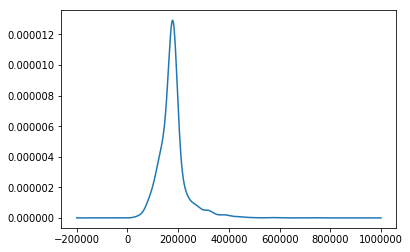

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

#before transformation
density = gaussian_kde(df.toPandas()["SalePrice"])
density.covariance_factor = lambda : .25
density._compute_covariance()

xs = np.linspace(-200000,1000000,3000)
plt.plot(xs,density(xs))
plt.show()


In [36]:
from pyspark.sql.functions import log10

## add 1 to prevent division by zero
df = df.withColumn('SalePrice', log10(F.col('SalePrice') + 1))


In [37]:
# convert SalePrice to Integer
#df = df.withColumn('SalePrice',df['SalePrice'].cast(IntegerType()))

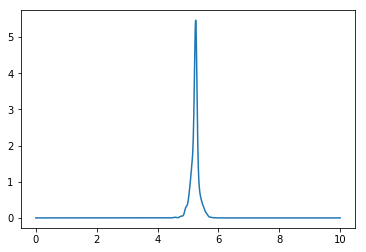

In [38]:
# after transformation
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

#before transformation
density = gaussian_kde(df.toPandas()["SalePrice"])
density.covariance_factor = lambda : .25
density._compute_covariance()

xs = np.linspace(0,10,3000)
plt.plot(xs,density(xs))
plt.show()

In [39]:
df.toPandas().to_csv('merged_df.csv')